# Rejection sampling

Rejection sampling is a technic that allows to sample from any distribution and dimensionalities.

Let's define some of the functions that we will need to use.

In [1]:
from typing import Optional
import os
from dataclasses import dataclass
from tqdm import tqdm

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

import gif


def _plot_sample_box(ax,
                     sample,
                     box_x: float = 0.05,
                     box_y: float = 0.95) -> None:
    # Show point info in top left corner
    z = sample.z
    text_l1 = f'\nz = {z:.4f}\n'
    text_l2 = r'P(Accept_z) = $\frac{P(z)}{kQ(z)}$ = ' + f'{sample.p_accept:.2f}'
    text = text_l1 + text_l2

    ax.text(box_x,
            box_y,
            text,
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment='top',
            bbox={'alpha':0.25, 'facecolor': 'goldenrod'})


def _plot_point(ax, points, marker_size: int, color: str) -> None:
    if points:
        x, y = zip(*((p.z, p.y) for p in points))
        ax.scatter(x, y, marker="x", s=marker_size, color=color)


@gif.frame
def plot_p_q(x,
             p,
             q = None,
             sample = None,
             points = None,
             display_sample_y: bool = True,
             marker_size: int = 50) -> None:

    p_x = p(x)

    # Plot p, q
    fig = plt.figure(figsize=(12, 6))
    ax = fig.gca()
    ax.plot(x, p_x, label='P')
    if q is not None:
        q_x = q(x)
        ax.plot(x, q(x), label='kQ')
    
    # If sampled point provided, show probabilities
    if q is not None and sample is not None:
        ax.vlines(sample.z, ymin=0, ymax=sample.q_z, color='red', label="kQ(z)")
        ax.vlines(sample.z, ymin=0, ymax=sample.p_z, color='lightgreen', label="P(z)")
        _plot_sample_box(ax, sample)
        
        if display_sample_y:
            ax.scatter(sample.z,
                       sample.y,
                       marker="x",
                       s=marker_size,
                       color="green" if sample.accept else "red")

    if points is not None:
        accepted = [p for p in points if p.accept]
        rejected = [p for p in points if not p.accept]
        _plot_point(ax, accepted, marker_size, color='green')
        _plot_point(ax, rejected, marker_size, color='red')

    # Visualization settings
    title = 'PDF for P(X)' if q is None else 'PDF for P(X) and Q(X)'
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.legend()

## Reference distribution

Let's get an arbitrary distribution $P(x)$ to sample from as a mixture of Gaussians:

$$
P(x) = \mathcal{N}(\mu=-1, \sigma=0.5) + \mathcal{N}(\mu=1, \sigma=0.7)
$$

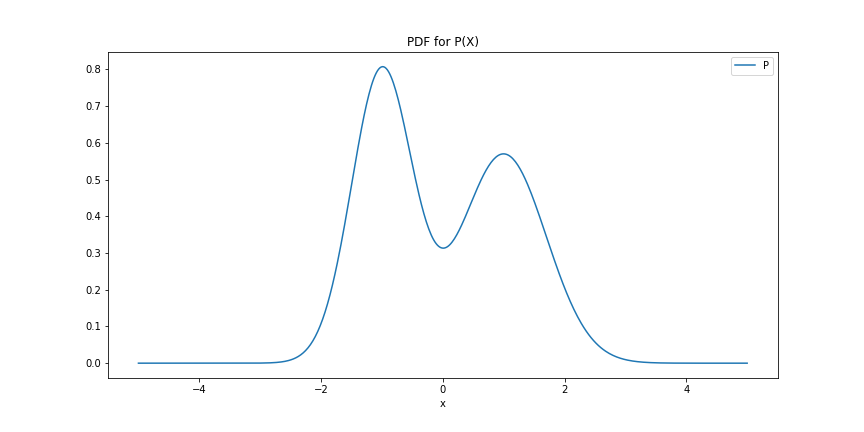

In [2]:
def p(x: np.ndarray) -> float:
    return norm(loc=-1, scale=0.5).pdf(x) + norm(loc=1, scale=0.7).pdf(x)

x = np.linspace(-5, 5, 500)
plot_p_q(x, p)

Note that we are using an unnormalized function (as it is usualy the case):
    
$$
P(x) = Z f(x)
$$

Where $Z$ is the normalization factor and $f$ is the normalized probability density.

Rejection sampling works with any distribution, even if it is not normalized. There is no need to re-scale $P(x)$.

## Finding distribution Q

In order to perform rejection sampling, we need to find a distribution $Q(x)$ we can sample from and that satisfies:

$$
k \ Q(x) \ge P(x) \ \forall x
$$

Let's use a simple Gaussian as $Q(x)$:

$$
Q(X) \sim \mathcal{N}(\mu=0.0, \sigma=1.0)
$$

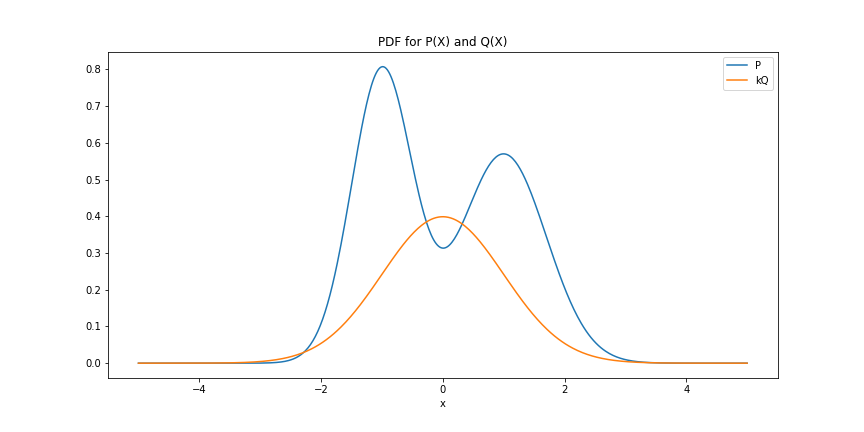

In [3]:
@dataclass
class Q:
    
    def __init__(self, k: int = 1):
        self.dist = norm(loc=0, scale=1.0)
        self.k = k
    
    def __call__(self, x):
        return self.dist.pdf(x) * self.k

    def sample(self):
        return self.dist.rvs()

plot_p_q(x, p, Q(k=1))

As we can see, $Q(x)$ fails to enclose $P(x)$ for $k=1$. We need to find a constant $k$ so the inequality holds:

$$
k = \underset{k}{\mathrm{argmin}} \ k \ Q(x) \ge P(x) \, \forall x
$$

Though we could eaisly solve this problem by choosing $k \gt \gt 0$, this would lead to a very unefficient sampling process (as we will see later), as most of the generated samples would be rejected.

Note that, in the unnormalized case:

$$
\begin{align*}
k & = \underset{k}{\mathrm{argmin}} \ k \ Q(x) \ge Z f(x) \, \forall x \\
  & = \underset{k}{\mathrm{argmin}} \ k Z \ Q(x) \ge f(x) \, \forall x \\
  & = \underset{k}{\mathrm{argmin}} \ k' \ Q(x) \ge f(x) \, \forall x \\
\end{align*}
$$

The constant found will also include the normalization factor for the original distribution.

In [5]:
def q_encloses_x(k: int) -> bool:
    return all(Q(k)(x) >= p(x))

ks = np.linspace(0, 5, 100)
found_k = False

for k_val in ks:

    if q_encloses_x(k=k_val):
        found_k = True
        k = k_val
        break

if not found_k:
    raise Exception(f"Could not find below {max_k}")
else:
    print(f"Found k={k}")

q = Q(k)

Found k=3.9393939393939394


Let's now plot the distributions again:

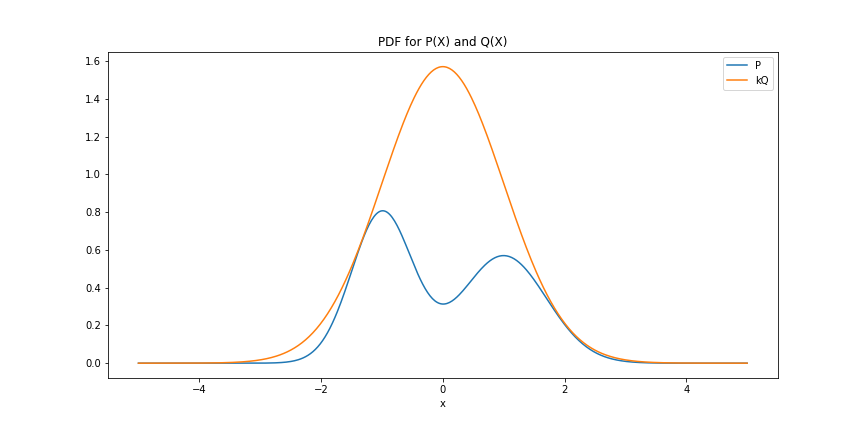

In [6]:
plot_p_q(x, p, q)

## Rejection sampling

The procedure for rejection sampling for a single point consists on the following steps:
    
1. Sample $z \sim Q$.
1. Compute acceptance probabily for $z$ as $\frac{P(z)}{kQ(z)}$ (i.e. rate between green line and red line below).
1. Sample $y \sim \mathcal{U}[0, kQ(z)]$ (i.e. sample uniformly between 0 and the height given by $kQ$ at sampled point z).
1. Accept point if $y \le P(z)$, therefore, if $y$ lies. Otherwise, reject it.

### Rejection sampling: visualization

Let's sample $z$ from $Q$, from which we should easily sample.

The probability of accepting $z$  will be proportional to the rate between height at $p(z)$ (i.e.green) and the height at $q(z)$ (i.e. red). The longer the green line, the higher the probability to sample a point at $x=z$.

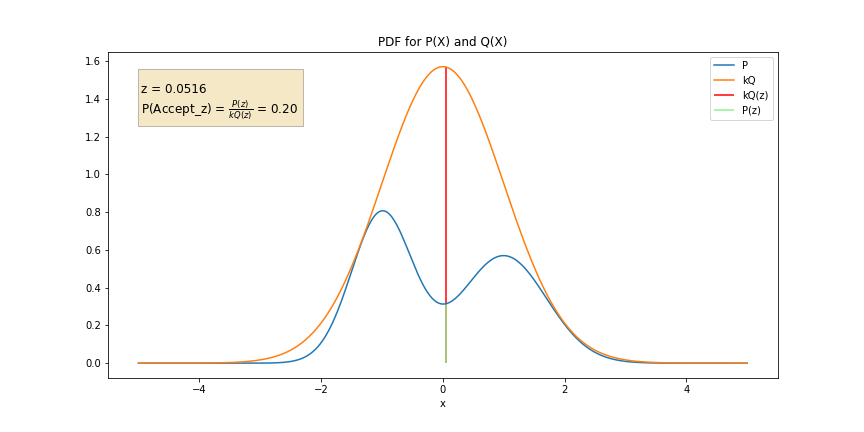

In [7]:
@dataclass
class SampleInfo:
    
    z: float
    y: float
    p_z: float
    q_z: float
    p_accept: float
    accept: bool


def try_accept(z: float, p: callable, q: Q) -> SampleInfo:
    # Compute acceptance probability
    q_z = q(z)
    p_z = p(z)
    acceptance_proba = p_z / q_z
    # Sample uniform from 0 to Q(z)
    # Accept if lying below P(z)
    y = np.random.uniform(0, q_z)
    accept = y <= p_z
    return SampleInfo(z=z,
                      y=y,
                      p_z=p_z,
                      q_z=q_z,
                      p_accept=acceptance_proba,
                      accept=accept)

# Sample from Q
z = q.sample()
plot_p_q(x, p, q, try_accept(z, p, q), display_sample_y=False)

In order to validate or reject the sample, we sample from $y$ uniformly from 0 to $q(z)$. If $y$ falls on the green line, we accept. Otherwise, we reject.

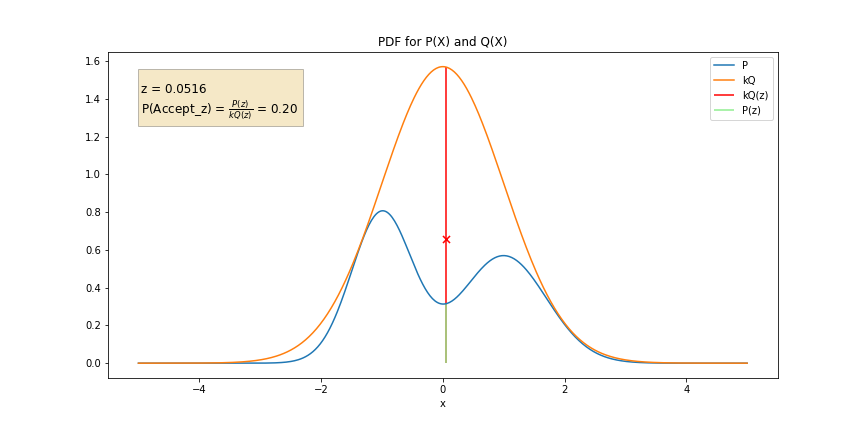

In [8]:
plot_p_q(x, p, q, try_accept(z, p, q), display_sample_y=True)

Note that we can sample again and have a different acceptance outcome.

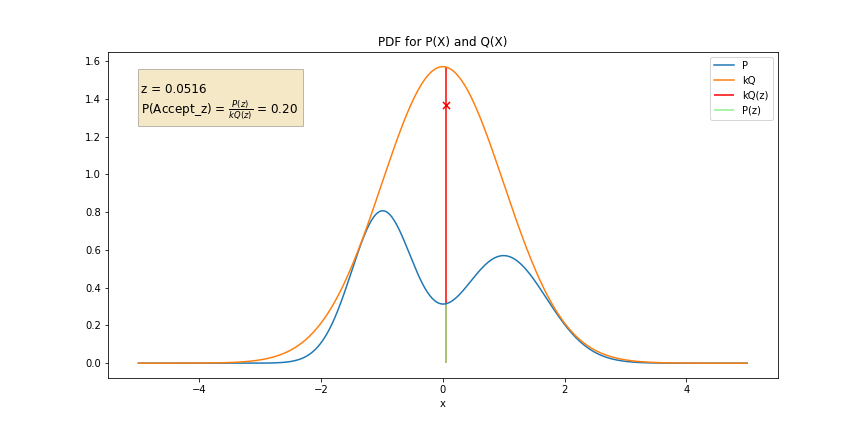

In [9]:
plot_p_q(x, p, q, try_accept(z, p, q), display_sample_y=True)

## Generate sample distribution

Let's try to generate 5000 samples.

In [10]:
frames = []
samples = []
n_samples = 1000

for i in tqdm(range(n_samples)):
    # Sample from Q
    z = q.sample()
    # Reject or accept z
    sample = try_accept(z, p, q)
    # Display z probabilities
    frame_before_y = plot_p_q(x,
                              p,
                              q,
                              sample,
                              display_sample_y=False,
                              points=samples)
    # Display z probabilities + sampled y
    frame_after_y = plot_p_q(x,
                             p,
                             q,
                             sample,
                             display_sample_y=True,
                             points=samples)
    frames += [frame_before_y, frame_after_y]
    # Save current point
    samples.append(sample)

100%|██████████| 1000/1000 [03:47<00:00,  4.39it/s]


In [10]:
animation_path = os.path.join('media', 'rejection_sampling.gif')

if not os.path.isfile(animation_path):
    gif.save(frames[:250], animation_path, duration=500)

![RejectionSampling](media/rejection_sampling.gif )

Let's plot all proposed samples.

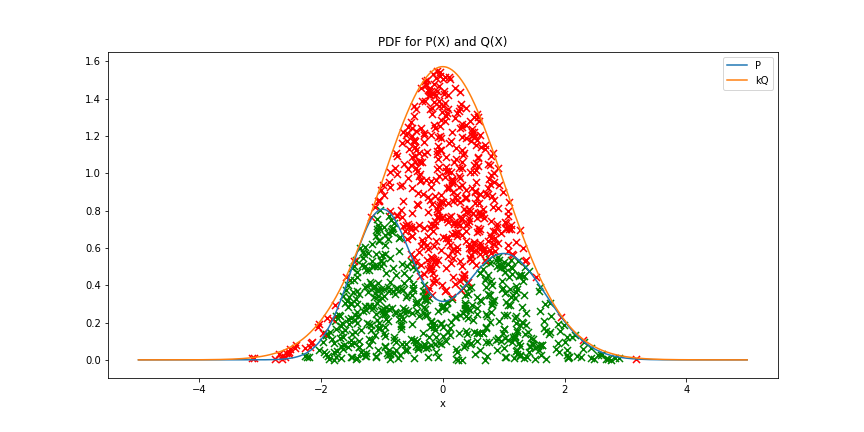

In [11]:
plot_p_q(x, p, q, points=samples)

A we sample form the uniform, the areas with more points will be those were there are the following two conditions:
        
- Q is more dense, as the probability of generating samples.
- P is more dense, as the rejecting distribution will be smaller.

## Sampling rate

Note that the choice of $Q$ determines the rate of acceptance of the sampled points. More precisely, the rate of acceptance equals to $\frac{1}{k}$ when $P(x)$ is normalized. It is straightforward, as the are under $f(x)$ is one and the area under $kQ(x)$ (assuming $Q(x)$ is also normalized), is $k$. Therefore, we will accept, on average, one for each $k$ points sampled.

When $P(x)$ is unnormalized, we have $P(x) = Z f(x)$. Therefore:

$$
\frac{k'}{Z} \ Q(x) \ge Z f(x) \ \forall x \\
$$

We see $k$ includes also the scaling/normalization factor. In these cases, acceptance rate is $\frac{1}{k'}$, which is straightforward to compute:

$$
k = \frac{k'}{Z} \rightarrow k' = k Z
$$

In this example, it is easy to compute Z as the area under the $P(x)$.

In [11]:
area_xs, area_step = np.linspace(-5, 5, 500, retstep=True)
Z = np.dot(area_step, p(area_xs)).sum()
k_prime = k / Z

Therefore, our rate of acceptance must be.

In [12]:
print(f'Rate of acceptance is: {1/k_prime:.2f}')

Rate of acceptance is: 0.51


We can see that approximately matches our acceptance rate during sampling.

In [13]:
n_accepted = len([x for x in samples if x.accept])
print(f'Observed acceptance rate: {n_accepted / n_samples}')

Observed acceptance rate: 0.502


## References

- [Lecture on sampling from University of Washington](https://faculty.washington.edu/yenchic/17Sp_403/Lec4_Importance.pdf)
- [Rejection sampling (Wikipedia)](https://en.wikipedia.org/wiki/Rejection_sampling)
- [Sampling from 1-d distributions](https://www.coursera.org/learn/bayesian-methods-in-machine-learning/lecture/XYaYu/sampling-from-1-d-distributions) (Coursera)